In [1]:
import numpy as np  
import random  
import time 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as la
from numpy.linalg import norm
import random
from functools import partial as curry


# Define the kernel functions

Linear Kernel: $$ K(X,Y)=X^T Y $$
Gaussian kernel:$$ K \left( X,Y \right ) = e^{ \left( - \frac{||X-Y||^2}{2\sigma^2} \right) },  \sigma > 0 $$
Polynomial kernel:$$ K \left( X,Y \right ) = (X^T Y + r)^n, r \geq 0  $$
Sigmoid kernel:$$ K \left( X,Y \right ) = tanh(\gamma X^T Y + r)$$

In [3]:
def k_linear(X, Y):
    return np.dot(X, Y)
def k_gaussian(X, Y, sigma = 0.01):
    return np.exp(-norm(X - Y) ** 2. / (2 * sigma ** 2))
def k_polynomial(X, Y, r = 0.01, n = 2):
    return (np.dot(X, Y) + r) ** n
def k_rbf(X, Y, gamma=1):
    return np.exp(- gamma * (np.linalg.norm(X - Y) ** 2))
def k_sigmoid(X, Y, gamma = 0.01, r = 0.01):
    return np.tanh(gamma * np.dot(X.T, Y) + r)

## to use kernel other than k_linear with extra arguments in the kernel argument
## one could use  kernel = curry(k_gaussian, sigma = 0.02)
kernel = curry(k_gaussian, sigma = 10)
X = np.array([0., 1.])
Y = np.array([1., 3.])
print(kernel(X, Y))

0.9753099120283326


# Define the SVM type

In [199]:
class SVM:
    def __init__(self, train, solver, kernel, c = 10):
        """
        ps is a list of [Y, *X]
        Y = 1 or -1(class)
        X is the features
        C is the cost
        solver is the solver function to get the support vector(w)
        """
        self.ps = train
        self.c = c
        self.solver = solver
        self.kernel = kernel
        self.w, self.b, self.alpha, self.history = solver(self.ps, self.kernel, self.c)
        
    def draw_history(self, from_index = 0):
        n = len(self.history) - 1
        arr = np.zeros(n - from_index, dtype = np.float64)
        for i in range(from_index, n):
            arr[i - from_index] = 0 if norm(self.history[i] - self.alpha) < 1e-6 else norm(self.history[i + 1] - self.alpha) / norm(self.history[i] - self.alpha)
        plt.plot(arr)
        plt.show()
        
    def classify(self, X):
        if self.kernel(self.w.T, X) + self.b > 1e-6:
            return 1
        else:
            return -1
    
    def judge(self, a):
        if a > 1e-6:
            return 1
        else:
            return 0
    def test(self, x, y):
        n = y.shape[0]
        stat = np.array([[0, 0], [0, 0]])
        for i in range(n):
            stat[self.judge(self.classify(x[i])), self.judge(y[i])] += 1
        prec   = stat[1, 1] / (stat[1, 1] + stat[1, 0])
        recall = stat[1, 1] / (stat[1, 1] + stat[0, 1])
#         return 2. * prec * recall / (prec + recall)
        return (stat[1, 1] + stat[0, 0]) / (stat[1, 1] + stat[1, 0] + stat[0, 0] + stat[0, 1])
#         return stat

# Define the dual form of optimization problem solver:
 $$L_D = \sum \limits_{i=1}^{m} \alpha_i - \frac{1}{2}\sum \limits_{i,j=1}^{m} y_i y_j \alpha_i \alpha_j (x_i)^{T} x_j$$
 $$ 0 \leq \alpha_i \leq C$$
 $$\sum \limits_{i=1}^{m} \alpha_i y_i = 0 \ \ \ \ \ for \ \ \ i = 1,...,m$$

# SMO
\begin{equation}
    \alpha_2^{new}=   
    \begin{cases}
    H & if \hat{\alpha_2} > H \\
    \hat{\alpha_2} & if L \leq \hat{\alpha_2} \leq H \\
    L & if \hat{\alpha_2} < L \\
    \end{cases}
    \end{equation}

In [5]:
# The SMO Solver
def smosolver(ps, kernel, c = 10, max_iter = 5000, EPS = 1e-6):
    n = len(ps)
    y = np.array(ps[:,0], dtype = np.float32)
    x = np.array(ps[:,1:], dtype = np.float32)
    idx = np.arange(0, n)
    alpha = np.zeros((n,))
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i][j] = kernel(x[i], x[j])
    b = 0              
    def f(i):
        sum = b
        for k in range(n):
            sum += y[k] * alpha[k] * K[i][k]
        return sum
    allf = lambda : np.array([f(i) for i in range(n)])
    history = []
    for i in range(max_iter):
        if i % 100 == 0:
            print(i)
        history.append(np.copy(alpha))
        a1 = int(np.random.rand() * n)
        a2 = int(np.random.rand() * (n - 1))
        if a2 >= a1:
            a2 += 1
        if abs(y[a1] - y[a2]) > EPS:
            L = max(0., alpha[a2] - alpha[a1])
            H = min(c, c + alpha[a2] - alpha[a1])
        else:
            L = max(0., alpha[a2] + alpha[a1] - c)
            H = min(c, alpha[a2] + alpha[a1])
        y1 = y[a1]
        y2 = y[a2]
        k11 = K[a1][a1]
        k22 = K[a2][a2]
        k12 = K[a1][a2]
        eta = k11 + k22 - 2 * k12
        if eta <= 0:
            continue
        a1old = alpha[a1]
        a2old = alpha[a2]
        e1 = f(a1) - y1
        e2 = f(a2) - y2
        a2new = np.clip(alpha[a2] + y2 * (e1 - e2) / eta, L, H)
        a1old, a2old = alpha[a1], alpha[a2]
        da2 = a2new - a2old
        da1 = -y2 * y1 * da2
        alpha[a2] = a2new
        alpha[a1] += da1
        b1 = b - e1 - y1 * k11 * da1 - y2 * k12 * da2
        b2 = b - e2 - y1 * k12 * da1 - y2 * k22 * da2
        if EPS < alpha[a1] < c - EPS:
            b = b1
        elif EPS < alpha[a2] < c - EPS:
            b = b2
        else:
            b = (b1 + b2) / 2
    history.append(alpha[:])
    w = np.dot(x.T, np.multiply(alpha,y))
    return (w, b, alpha, history)

#### GD-$\alpha$-solver
This is method which implement by mixing QP and basic GD. 
#### The objective function for QP
$$Q(\alpha) = \frac{1}{2}\alpha H \alpha - \sum \limits_{i=1}^{m} \alpha_i + \mu_k \sum \limits_{i=1}^{m} max(|\alpha_i - \frac{C}{2}| - \frac{C}{2}, 0)^2 + \lambda(\sum \limits_{i=1}^{m} \alpha_i y_i)^2$$
#### The gradient function of QP
$$\frac{\partial{Q(\alpha)}}{\partial{\alpha_i}} = [A\alpha]_i -1 + 2\mu_k clip(\alpha) + \lambda(2\alpha^{T}y)y_i$$


Using a GD to minimize the norm of this vector:
   $$(|f(x_0) \cdot y_0 - 1|,\quad |f(x_1) \cdot y_1 - 1|, \quad ... |f(x_n)\cdot y_n - 1|) +( \quad clip(\alpha_0),\quad clip(\alpha_1),\quad ...,\quad clip(\alpha_n)\ ) + \quad (|\Sigma{\alpha_i y_iy_j|}) $$
   
   The clip is defined as:
       $$ \quad\quad\quad\quad -2\alpha \quad if\quad a < 0$$
       $$ clip(\alpha) = 0\quad if\quad 0 < a < c$$
       $$ \quad\quad\quad\quad 2(\alpha - c)\quad if\quad a > c$$

In [165]:
# The Quadratic Penalty Solver by Gradient Descent
def gdalphasolver(ps, kernel, c = 10, max_iter = 50, EPS = 1e-12):
    y = np.array(ps[:,0], dtype = np.float64)
    x = np.array(ps[:,1:], dtype = np.float64)
    n, d = x.shape
    w = np.zeros(d, dtype = np.float64)
    alpha = np.zeros(n, dtype = np.float64)
    
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i][j] = kernel(x[i], x[j])
    b = 0              
    def f(i):
        sum = b
        for k in range(n):
            sum += y[k] * alpha[k] * K[i][k]
        return sum
    
    clip = lambda v: 2*abs(v) if v < 0 else (2*abs(v - c) if v > c else 0)
    allf = lambda : np.array([f(i) * y[i] - 1 for i in range(n)] + 
                             [clip(alpha[i]) for i in range(n)] +
                             [(np.dot(alpha, y))*y[i] for i in range(n)])
    b = 0.
    eta = 1e-4
    history = []
    while norm(allf()) > EPS and max_iter > 0:
        history.append(np.copy(alpha))
        print(max_iter)
        ss = norm(allf())
        i = int(np.random.rand() * n)
        old = alpha[i]
        alpha[i] = (1 - eta) * alpha[i] - eta * c
        if norm(allf()) > ss:
            alpha[i] = (1 - eta) * old + eta * c
        w = np.dot(x.T, np.multiply(alpha, y))
        b = np.mean(y - kernel(x, w))
        max_iter -= 1
    history.append(alpha[:])
    return (w, b, alpha, history)

In [193]:
positive_phi = np.random.uniform(low=0, high=2*np.pi, size=400)
positive_rho = np.random.uniform(low=2, high=4, size=400)
negative_phi = np.random.uniform(low=0, high=2*np.pi, size=400)
negative_rho = np.random.uniform(low=0, high=2, size=400)

def pol2cart(rho, phi):
    '''
    function convert polar coordinates to cartisian coordinates
    '''
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

positive_x, positive_y = pol2cart(positive_rho, positive_phi)
negative_x, negative_y = pol2cart(negative_rho, negative_phi)

x = np.zeros((800, 2))

x[0:400, 0] = positive_x
x[0:400, 1] = positive_y

x[400: , 0] = negative_x
x[400: , 1] = negative_y

y = np.zeros((800,1))

y[0:400] = 1
y[400: ] = -1

train_data = np.hstack((y, x))
train_xs = x
train_ys = y

#### Then, we visulize our data set

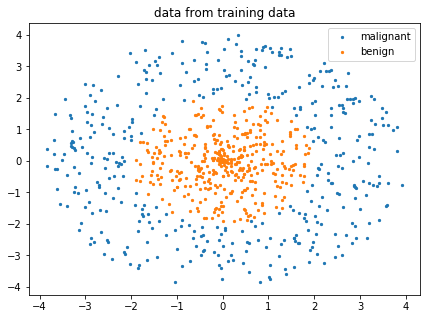

In [194]:
def plot_dataset(xs, ys):
    malignant1 = plt.scatter(xs[ys.squeeze() == 1, 0], xs[ys.squeeze() == 1, 1], label = 'malignant', s = 5)
    benign1 = plt.scatter(xs[ys.squeeze() == -1, 0], xs[ys.squeeze() == -1, 1], label = 'benign', s = 5)
    plt.title('data from training data')
    plt.legend(loc = 'upper right')
    
plt.figure(figsize=(7, 5))
plot_dataset(train_xs, train_ys)
plt.show()

Now, we start to try linear kernel and SMO algorithm firstly.

In [40]:
time_start  = time.time()
svm = SVM(train_data, smosolver, kernel = k_linear)
time_end = time.time()
print('totally cost',time_end-time_start)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
totally cost 20.6719491481781


In [41]:
print(svm.w, svm.b)
print(np.shape(svm.alpha))
print('Train data fscore', svm.test(train_xs, train_ys))

[-0.20696918  0.60298412] -1.3008972397152432
(800,)
Train data fscore (0.615, array([[400, 308],
       [  0,  92]]))


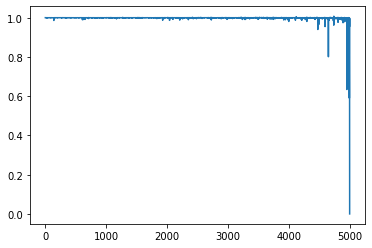

In [42]:
# The plot of alpha's convergence
svm.draw_history()

The following trial is about using polynomial kernel

In [188]:
time_start  = time.time()
svm1 = SVM(train_data, smosolver, kernel = k_polynomial)
time_end = time.time()
print('totally cost',time_end-time_start)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
totally cost 22.353877067565918


In [189]:
print(svm1.w, svm1.b)
print('Train data fscore', svm1.test(train_xs, train_ys))

[-0.11008675  2.45193725] -8.509221290335049
Train data fscore (0.77875, array([[325, 102],
       [ 75, 298]]))


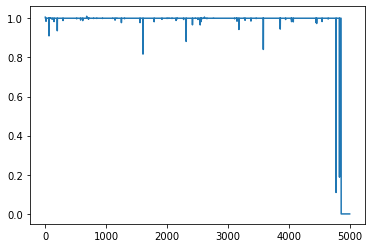

In [190]:
# The plot of alpha's convergence
svm1.draw_history()


The following code is for visulize the result our second trial.

Text(0.5, 1.0, 'The trained model of SMO mthod')

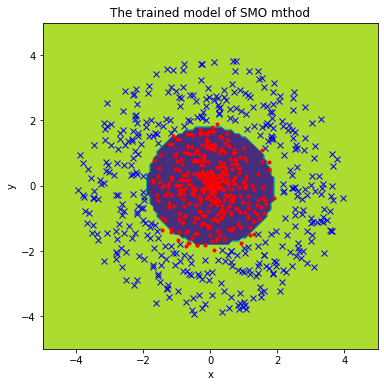

In [171]:
def fx_predict(ps, point, alpha, b, kernel = k_polynomial):
    '''
    calculate f(x) with kernels
    '''
    y = np.array(ps[:,0])
    x = np.array(ps[:,1:])
    fx = 0
    
    for j in range(np.size(y)):
        fx += alpha[j] * y[j] * kernel(x[j], point)
    
    ff = fx + b
    if ff >= 0:
        return 1
    if ff < 0:
        return -1
                   
x_plot = y_plot = np.linspace(-5, 5, 100)
z_plot = np.array([fx_predict(
    train_data, np.array([i, j]), svm1.alpha, svm1.b) for j in y_plot for i in x_plot])
Z = z_plot.reshape(100,100)
plt.figure(figsize=(6,6))

plt.plot(positive_x, positive_y, 'bx')
plt.plot(negative_x, negative_y, 'r.')
plt.contourf(x_plot, x_plot, Z, 3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('The trained model of SMO mthod')

In [201]:
time_start  = time.time()
svm2 = SVM(train_data, smosolver, kernel = k_gaussian)
time_end = time.time()
print('totally cost',time_end-time_start)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
totally cost 27.600088119506836


In [202]:
print(svm2.w, svm2.b)
# print(f'Train data fscore = {svm.test(train_xs, train_ys)}')
# print(f'Test data fscore = {svm.test(test_xs, test_ys)}')
print('Train data fscore', svm2.test(train_xs, train_ys))
# print('Test data fscore', svm2.test(test_xs, test_ys))

[19.79336584 42.4267835 ] -0.015583488966040615
Train data fscore 0.5


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars


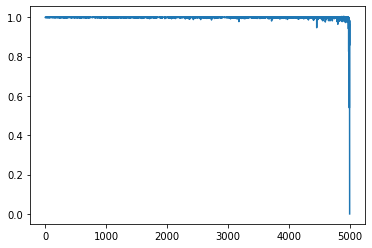

In [203]:
svm2.draw_history()

From this three trials for linear, polynomial, gaussian kernel under SMO algorithm, we can find the polynomial have
a best performance. And Gaussian costs the much time due to the complexity of computing. 

Next, we start to try QP method under the same random data set. And the first trial kernel is linear.

In [166]:
time_start  = time.time()
svml = SVM(train_data, gdalphasolver, kernel = k_linear, c = 10)
time_end = time.time()
print('totally cost',time_end-time_start)

50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
totally cost 56.58932900428772


In [157]:
print(svml.w, svml.b)
# print(f'Train data fscore = {svm.test(train_xs, train_ys)}')
# print(f'Test data fscore = {svm.test(test_xs, test_ys)}')
print('Train data fscore', svml.test(train_xs, train_ys))
# print('Test data fscore', svm3.test(test_xs, test_ys))

[ 0.00176628 -0.01844063] -0.0006881355668120648
Train data fscore (0.5275, array([[218, 196],
       [182, 204]]))


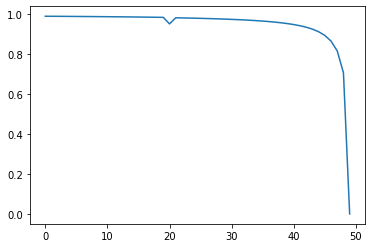

In [191]:
svml.draw_history()

The second trial is about using polynomial kernel.

In [176]:
time_start  = time.time()
svm3 = SVM(train_data, gdalphasolver, kernel = k_polynomial, c = 10)
time_end = time.time()
print('totally cost',time_end-time_start)

50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
totally cost 54.59557580947876


In [177]:
print(svm3.w, svm3.b)
# print(f'Train data fscore = {svm.test(train_xs, train_ys)}')
# print(f'Test data fscore = {svm.test(test_xs, test_ys)}')
print('Train data fscore', svm3.test(train_xs, train_ys))
# print('Test data fscore', svm3.test(test_xs, test_ys))

[-0.00550771 -0.01198897] -0.0005543912174703536
Train data fscore (0.705, array([[355, 191],
       [ 45, 209]]))


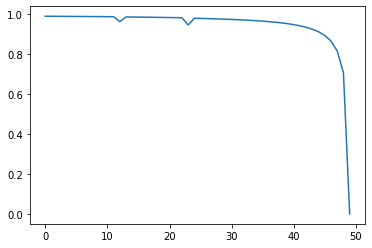

In [178]:
svm3.draw_history()

The third trial kernel is Gaussian

In [80]:
time_start  = time.time()
svm4 = SVM(train_data, gdalphasolver, kernel = k_gaussian, c = 10)
time_end = time.time()
print('totally cost',time_end-time_start)

50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
totally cost 57.732646226882935


In [81]:
print(svm4.w, svm4.b)
# print(f'Train data fscore = {svm.test(train_xs, train_ys)}')
# print(f'Test data fscore = {svm.test(test_xs, test_ys)}')
print('Train data fscore', svm4.test(train_xs, train_ys))
# print('Test data fscore', svm4.test(test_xs, test_ys))

[0.01029467 0.01136896] 0.0
Train data fscore (0.48375, array([[387, 400],
       [ 13,   0]]))


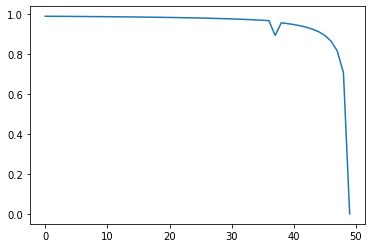

In [82]:
svm4.draw_history()

From this three trials, we can find same results with previuos three trials on SMO.

In conclusion, SMO have better performance than QP because SMO can have more iterations with less time. And Polynomial 
kernel have better performance for this data set.